# Context Summarization

## Background from Drew's Post

Context summarization involves condensing accumulated context into shorter versions to prevent context distraction. Drew Breunig highlights key research findings:

- **Gemini research found performance issues with contexts over 100,000 tokens**
- **Prevents "Context Distraction"** where models focus too much on accumulated history
- **Helps models focus on novel reasoning** instead of repeating historical actions
- **Essential for long-running conversations** that can span hundreds of turns

Key insights from Drew's research:
- Context summarization prevents models from becoming overly focused on historical context
- Critical for maintaining performance in extended interactions
- Can be implemented at various points in an agent's trajectory
- Often requires careful engineering to preserve essential information

## Context Summarization in Practice

Agent interactions can span [hundreds of turns](https://www.anthropic.com/engineering/built-multi-agent-research-system) and use token-heavy tool calls. Summarization is one common way to manage these challenges. If you've used Claude Code, you've seen this in action. Claude Code runs "[auto-compact](https://docs.anthropic.com/en/docs/claude-code/costs)" after you exceed 95% of the context window and it will summarize the full trajectory of user-agent interactions. This type of compression across an [agent trajectory](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-short-term-memory) can use various strategies such as [recursive](https://arxiv.org/pdf/2308.15022#:~:text=the%20retrieved%20utterances%20capture%20the,based%203) or [hierarchical](https://alignment.anthropic.com/2025/summarization-for-monitoring/#:~:text=We%20addressed%20these%20issues%20by,of%20our%20computer%20use%20capability) summarization.

It can also be useful to [add summarization](https://github.com/langchain-ai/open_deep_research/blob/e5a5160a398a3699857d00d8569cb7fd0ac48a4f/src/open_deep_research/utils.py#L1407) at points in an agent's trajectory. For example, it can be used to post-process certain tool calls (e.g., token-heavy search tools). As a second example, [Cognition](https://cognition.ai/blog/dont-build-multi-agents#a-theory-of-building-long-running-agents) mentioned summarization at agent-agent boundaries to knowledge hand-off. They also the challenge if specific events or decisions to be captured. They use a fine-tuned model for this in Devin, which underscores how much work can go into this step.

### Summarization in LangGraph

Because LangGraph is a low [is a low-level orchestration framework](https://blog.langchain.com/how-to-think-about-agent-frameworks/), you can [lay out your agent as a set of nodes](https://www.youtube.com/watch?v=aHCDrAbH_go), [explicitly define](https://blog.langchain.com/how-to-think-about-agent-frameworks/) the logic within each one, and define an state object that is passed between them. This low-level control gives several ways to compress context.

You can use a message list as your agent state and [summarize](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#manage-short-term-memory) using [a few built-in utilities](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#manage-short-term-memory).

In [11]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [13]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings import init_embeddings

embeddings = init_embeddings("openai:text-embedding-3-small")
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [14]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

# TODO: Add rich formatting
retriever_tool.invoke({"query": "types of reward hacking"})

'Experiments in two RL environments, CoinRun and Maze, demonstrated the importance of randomization during training. If during training, the coin or the cheese is placed at a fixed position (i.e. right end of the level or upper right corner of the maze) but testing in the env where the coin or cheese is placed at random, the agent would just run to the fixed position without obtaining the coin or cheese at test time. A conflict arises when a visual feature (e.g., cheese or coin) and a positional feature (e.g., upper-right or right end) are inconsistent during test time, leading the trained model to prefer the positional feature. I would like to point out that, in these two examples, the reward-result gaps are clear but such type of biases are unlikely to be so obvious in most real-world cases.\n\n\nThe impact of randomizing the position of the coin during training. When the coin is placed at random for {0, 2, 3, 6, 11}% of the time during training (x-axis), the frequency of the agent n

In [15]:
from langchain.chat_models import init_chat_model

# Initialize the language model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Set up tools and bind them to the LLM
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

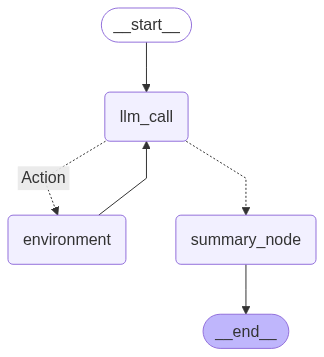

In [16]:
from typing_extensions import Literal

from IPython.display import Image, display
from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, MessagesState, StateGraph

# Define extended state with summary field
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str

# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

# Define the summarization prompt
summarization_prompt = """Summarize the full chat history and all tool feedback to 
give an overview of what the user asked about and what the agent did."""

def llm_call(state: MessagesState) -> dict:
    """Execute LLM call with system prompt and message history.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with new messages
    """
    messages = [SystemMessage(content=rag_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def tool_node(state: MessagesState) -> dict:
    """Execute tool calls and return results.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def summary_node(state: MessagesState) -> dict:
    """Generate a summary of the conversation and tool interactions.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with conversation summary
    """
    messages = [SystemMessage(content=summarization_prompt)] + state["messages"]
    result = llm.invoke(messages)
    return {"summary": result.content}


def should_continue(state: MessagesState) -> Literal["Action", "summary_node"]:
    """Determine next step based on whether LLM made tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node to execute
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # If LLM made tool calls, execute them
    if last_message.tool_calls:
        return "Action"
    # Otherwise, proceed to summarization
    return "summary_node"

# Build the RAG agent workflow
agent_builder = StateGraph(State)

# Add nodes to the workflow
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)
agent_builder.add_node("summary_node", summary_node)

# Define the workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "environment",
        "summary_node": "summary_node",
    },
)
agent_builder.add_edge("environment", "llm_call")
agent_builder.add_edge("summary_node", END)

# Compile the agent
agent = agent_builder.compile()

# Display the agent workflow
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
from utils import format_messages
query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": query})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Why does RL improve LLM reasoning according to the blogs?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you find information about how reinforcement learning (RL) improves LLM reasoning according to Lilian │
│ Weng's blog posts. Let me search for relevant content on this topic.                                            │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "reinforcement learning RL improve LLM reasoning"                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Illustration of parallel sampling vs sequential revision.                                                       │
│                                                                                                                 │
│ Parallel Sampling#                                                                                              │
│ Given a generative model and a scoring function that we can use to score full or partial samples, there are     │
│ various search algorithms we can use to find a high scoring sample. Best-of-$N$ is the simplest such algorithm: │
│ one just collects $N$ independent samples and chooses the highest-ranking sample according to some scoring      │
│ function. Beam search is a more sophisticated search algorithm that makes the search process more adaptive,     │
│ spending more sampling computation on more promising parts of the solution space.                               │
│ Beam search maintains a set of promising partial sequences and alternates between extending them and pruning    │
│ the less promising ones. As a selection mechanism, we can use a process reward model (PRM; Lightman et al.      │
│ 2023) to guide beam search candidate selection. Xie et al. (2023) used LLM to evaluate how likely its own       │
│ generated reasoning step is correct, formatted as a multiple-choice question and found that per-step            │
│ self-evaluation reduces accumulative errors in multi-step reasoning during beam search decoding. Besides,       │
│ during sampling, annealing the temperature helps mitigate aggregated randomness. These experiments by Xie et    │
│ al. achieved 5-6% improvement on few-shot GSM8k, AQuA and StrategyQA benchmarks with the Codex model. Reward    │
│ balanced search (short for “REBASE”; Wu et al. 2025) separately trained a process reward model (PRM) to         │
│ determine how much each node should be expanded at each depth during beam search, according to the              │
│ softmax-normalized reward scores. Jiang et al. (2024) trained their PRM, named “RATIONALYST”, for beam search   │
│ guidance on synthetic rationales conditioned on a large amount of unlabelled data. Good rationales are filtered │
│ based on whether they help reduce the neg log-prob of true answer tokens by a threshold, when comparing the     │
│ difference between when the rationales is included in the context vs not. At inference time, RATIONALYST        │
│ provides process supervision to the CoT generator by helping estimate log-prob of next reasoning steps          │
│ (“implicit”) or directly generating next reasoning steps as part of the prompt (“explicit”).                    │
│                                                                                                                 │
│                                                                                                                 │
│ Beam search decoding guided by LLM self-evaluation per reasoning step. (Image source: Xie et al. 2023)          │
│                                                                                                                 │
│ Interestingly, it is possible to trigger the emergent chain-of-thought reasoning paths without explicit         │
│ zero-shot or few-shot prompting. Wang & Zhou (2024) discovered that if we branch out at the first sampling      │
│ tokens by retaining the top $k$ tokens with highest confidence, measured as the difference between top-1 and    │
│ top-2 candidates during sampling, and then continue these $k$ sampling trials with greedy decoding onward, many │
│ of these sequences natively contain CoT. Especially when CoT does appear in the context, it leads to a more     │
│ confident decoding of the final answer. To calculate the confidence of the final answer, the answer span needs  │
│ to be identified by task-specific heuristics (e.g. last

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about the mechanisms by which RL improves reasoning in LLMs.        │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "RL reinforcement learning reasoning mechanisms chain of thought CoT training"                       │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ , such that we prioritize samples with CoTs that are good at predicting the observation (i.e., high $p(x \mid   │
│ z^{(k)})$), simple, intuitive (i.e., high $p(z^{(k)})$) but also informative and not too obvious (i.e. low      │
│ $q(z^{(k)} \mid x)$).                                                                                           │
│ Iterative Learning#                                                                                             │
│ Since pretrained models already possess the capability of generating chains of thought, it is intuitive to      │
│ design an iterative improvement process where we generate multiple CoTs and fine-tune the model only on         │
│ rationales that lead to correct answers.                                                                        │
│ However, this straightforward design can fail because the model receives no learning signals for problems it    │
│ fails to solve. STaR (“Self-taught reasoner”; Zelikman et al. 2022) addresses this limitation by adding a       │
│ “rationalization” process for failed attempts, in which the model generates good CoTs backward conditioned on   │
│ both the problem and the ground truth answer and thus the model can generate more reasonable CoTs. Then the     │
│ model is finetuned on correct solutions that either lead to correct outputs or are generated through            │
│ rationalization.                                                                                                │
│                                                                                                                 │
│                                                                                                                 │
│ The algorithm of STaR. (Image source: Zelikman et al. 2022)                                                     │
│                                                                                                                 │
│ We can view STaR as an approximation to a policy gradient in RL, with a simple indicator function as the        │
│ reward, $\mathbb{1}[\hat{y} = y]$. We want to maximize the expectation of this reward when sampling $z \sim p(z │
│ \mid x)$ and then $y \sim p(y \mid x, z)$, since $p(y \mid x) = \sum_z p(z \mid x) \; p(y \mid x, z)$.          │
│                                                                                                                 │
│ $$                                                                                                              │
│ \begin{aligned}                                                                                                 │
│ \nabla_\theta J(\theta)                                                                                         │
│ &= \nabla_\theta \mathbb{E}_{z_i, y_i \sim p(.\mid x_i)} \mathbb{1} \\                                          │
│ &= \sum_{i=1}^N \nabla_\theta \mathbb{1} \; p(y_i, z_i \mid x_i) \\                                             │
│ &= \sum_{i=1}^N \mathbb{1} \; p(y_i, z_i \mid x_i) \frac{\nabla_\theta p(y_i, z_i \mid x_i)}{p(y_i, z_i \mid    │
│ x_i)} & \text{;log-derivative trick}\\                                                                          │
│ &= \mathbb{E}_{z_i, y_i \sim p(.\mid x_i)} \mathbb{1} \; \nabla_\theta \log p(y_i, z_i \mid x_i) &              │
│ \text{;log-derivative trick}                                                                                    │
│ \end{aligned}                                                                                                   │
│ $$                                                                                                              │
│                                                                                                                 │
│ Each iteration is equivalent to first selecting the CoT

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more information about the specific mechanisms and benefits of RL for reasoning.              │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "RL training accuracy rewards format rewards DeepSeek reasoning benefits"                            │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Illustration of parallel sampling vs sequential revision.                                                       │
│                                                                                                                 │
│ Parallel Sampling#                                                                                              │
│ Given a generative model and a scoring function that we can use to score full or partial samples, there are     │
│ various search algorithms we can use to find a high scoring sample. Best-of-$N$ is the simplest such algorithm: │
│ one just collects $N$ independent samples and chooses the highest-ranking sample according to some scoring      │
│ function. Beam search is a more sophisticated search algorithm that makes the search process more adaptive,     │
│ spending more sampling computation on more promising parts of the solution space.                               │
│ Beam search maintains a set of promising partial sequences and alternates between extending them and pruning    │
│ the less promising ones. As a selection mechanism, we can use a process reward model (PRM; Lightman et al.      │
│ 2023) to guide beam search candidate selection. Xie et al. (2023) used LLM to evaluate how likely its own       │
│ generated reasoning step is correct, formatted as a multiple-choice question and found that per-step            │
│ self-evaluation reduces accumulative errors in multi-step reasoning during beam search decoding. Besides,       │
│ during sampling, annealing the temperature helps mitigate aggregated randomness. These experiments by Xie et    │
│ al. achieved 5-6% improvement on few-shot GSM8k, AQuA and StrategyQA benchmarks with the Codex model. Reward    │
│ balanced search (short for “REBASE”; Wu et al. 2025) separately trained a process reward model (PRM) to         │
│ determine how much each node should be expanded at each depth during beam search, according to the              │
│ softmax-normalized reward scores. Jiang et al. (2024) trained their PRM, named “RATIONALYST”, for beam search   │
│ guidance on synthetic rationales conditioned on a large amount of unlabelled data. Good rationales are filtered │
│ based on whether they help reduce the neg log-prob of true answer tokens by a threshold, when comparing the     │
│ difference between when the rationales is included in the context vs not. At inference time, RATIONALYST        │
│ provides process supervision to the CoT generator by helping estimate log-prob of next reasoning steps          │
│ (“implicit”) or directly generating next reasoning steps as part of the prompt (“explicit”).                    │
│                                                                                                                 │
│                                                                                                                 │
│ Beam search decoding guided by LLM self-evaluation per reasoning step. (Image source: Xie et al. 2023)          │
│                                                                                                                 │
│ Interestingly, it is possible to trigger the emergent chain-of-thought reasoning paths without explicit         │
│ zero-shot or few-shot prompting. Wang & Zhou (2024) discovered that if we branch out at the first sampling      │
│ tokens by retaining the top $k$ tokens with highest confidence, measured as the difference between top-1 and    │
│ top-2 candidates during sampling, and then continue these $k$ sampling trials with greedy decoding onward, many │
│ of these sequences natively contain CoT. Especially when CoT does appear in the context, it leads to a more     │
│ confident decoding of the final answer. To calculate the confidence of the final answer, the answer span needs  │
│ to be identified by task-specific heuristics (e.g. last

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the information from Lilian Weng's blog posts, here's why RL improves LLM reasoning according to her   │
│ analysis:                                                                                                       │
│                                                                                                                 │
│ ## Key Mechanisms of RL for Improving LLM Reasoning                                                             │
│                                                                                                                 │
│ ### 1. **Direct Reward Optimization for Correctness**                                                           │
│ RL improves reasoning by directly rewarding models for getting correct answers. According to the blogs, there   │
│ has been "a lot of recent success in using RL to improve the reasoning ability of language models, by using a   │
│ collection of questions with ground truth answers (usually STEM problems and puzzles with easy to verify        │
│ answers), and rewarding the model for getting the correct answer."                                              │
│                                                                                                                 │
│ ### 2. **Two-Type Reward Structure**                                                                            │
│ The DeepSeek-R1 example illustrates how RL uses structured rewards:                                             │
│ - **Format rewards**: Encouraging proper reasoning structure (wrapping chain-of-thought in `<thinking>` tags)   │
│ - **Accuracy rewards**: Directly rewarding correct final answers (verified through specific formats for math    │
│ problems or compiler tests for coding)                                                                          │
│                                                                                                                 │
│ ### 3. **Emergent Self-Correction and Reflection**                                                              │
│ RL training enables models to develop sophisticated reasoning behaviors:                                        │
│ - **"Aha moments"**: The model learns to reflect on previous mistakes and try alternative approaches            │
│ - **Self-correction capabilities**: Through multi-turn RL approaches like SCoRe, models learn to produce better │
│ answers on second attempts                                                                                      │
│ - **Backtracking**: Models naturally learn to reconsider and revise their reasoning paths                       │
│                                                                                                                 │
│ ### 4. **Iterative Learning Through STaR**                                                                      │
│ The Self-Taught Reasoner (STaR) approach shows how RL-like training improves reasoning:                         │
│ - Models generate multiple chain-of-thought (CoT) paths                                                         │
│ - Only correct reasoning paths are reinforced through fine-tuning                                               │
│ - For failed attempts, models learn through "rationalization" - generating good CoTs backward from correct      │
│ answers                                                                                                         │
│ - This approximates policy gradient RL with a simple reward function                                            │
│                                                                                                                 │
│ ### 5. **Enhanced Test-Time Compute Utilization**                                                               │
│ RL training teaches models to effectively use additiona

In [ ]:
from rich.markdown import Markdown
Markdown(result["summary"])

#### Summarize Tools

Let's update the RAG agent, and add summarization the tool call output.

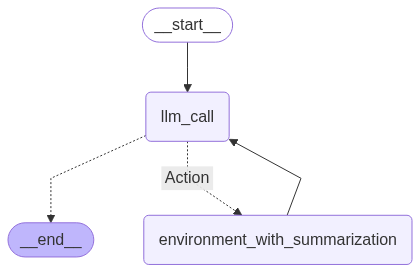

In [9]:
tool_summarization_prompt = """You will be provided a doc from a RAG system.
Summarize the docs, ensuring to retain all relevant / essential information.
Your goal is simply to reduce the size of the doc (tokens) to a more manageable size."""

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

def tool_node_with_summarization(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        # Summarize the doc
        summary = llm.invoke([{"role":"system",
                              "content":tool_summarization_prompt},
                              {"role":"user",
                               "content":observation}])
        result.append(ToolMessage(content=summary.content, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment_with_summarization", tool_node_with_summarization)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment_with_summarization",
        END: END,
    },
)
agent_builder.add_edge("environment_with_summarization", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [10]:
query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": query})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Why does RL improve LLM reasoning according to the blogs?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you find information about how reinforcement learning (RL) improves LLM reasoning according to Lilian │
│ Weng's blog posts. Let me search for relevant content on this topic.                                            │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "reinforcement learning RL improve LLM reasoning"                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Summary: Parallel Sampling vs Sequential Revision in LLM Reasoning                                            │
│                                                                                                                 │
│ ## Parallel Sampling                                                                                            │
│ **Best-of-N and Beam Search**: Simple parallel sampling collects N independent samples and selects the          │
│ highest-scoring one. Beam search is more sophisticated, maintaining promising partial sequences and using       │
│ process reward models (PRMs) for guidance.                                                                      │
│                                                                                                                 │
│ **Key Techniques**:                                                                                             │
│ - **Self-evaluation**: LLMs evaluate their own reasoning steps during beam search, achieving 5-6% improvement   │
│ on math benchmarks                                                                                              │
│ - **REBASE**: Uses trained PRMs to determine node expansion during beam search                                  │
│ - **RATIONALYST**: Provides process supervision by estimating log-probabilities of reasoning steps              │
│ - **Top-k branching**: Branches at first token based on confidence (difference between top-1 and top-2          │
│ candidates), triggering emergent CoT reasoning                                                                  │
│                                                                                                                 │
│ ## Sequential Revision                                                                                          │
│ **Self-Correction Challenges**: LLMs lack intrinsic self-correction capabilities and suffer from hallucination, │
│ behavior collapse, and generalization failures. External feedback is essential for improvement.                 │
│                                                                                                                 │
│ **Training Approaches**:                                                                                        │
│ - **Self-correction learning**: Trains corrector models using value-improving pairs from multiple outputs       │
│ - **Recursive inspection**: Single model performs both generation and self-correction                           │
│ - **SCoRe**: Two-stage RL approach preventing behavior collapse while improving both first and second attempts  │
│                                                                                                                 │
│ ## RL for Better Reasoning                                                                                      │
│ **DeepSeek-R1**: Uses cold-start SFT, reasoning-oriented RL with format/accuracy rewards, and rejection         │
│ sampling combined with non-reasoning SFT.                                                                       │
│                                                                                                                 │
│ **STaR (Self-taught Reasoner)**: Iterative improvement process generating multiple CoTs, fine-tuning on correct │
│ solutions, and using "rationalization" for failed attempts by generating CoTs backward from ground truth.       │
│                                                                                                                 │
│ ## Scaling Laws for Thinking Time                                                                               │
│ **Test-time vs Pretraining Compute**: Test-time compute can be more effective than scaling parameters for       │
│ smaller capability gaps, but pretraining remains critic

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about the mechanisms by which RL improves reasoning in LLMs.        │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "RL reinforcement learning chain of thought reasoning training mechanisms"                           │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Summary: Parallel Sampling vs Sequential Revision for LLM Reasoning                                           │
│                                                                                                                 │
│ ## Parallel Sampling                                                                                            │
│ **Best-of-N and Beam Search**: Simple approach samples N independent outputs and selects highest-scoring. Beam  │
│ search is more sophisticated, maintaining promising partial sequences and using process reward models (PRMs)    │
│ for guidance.                                                                                                   │
│                                                                                                                 │
│ **Key Techniques**:                                                                                             │
│ - **Self-evaluation**: LLMs evaluate their own reasoning steps as multiple-choice questions, reducing errors in │
│ multi-step reasoning (5-6% improvement on GSM8k, AQuA, StrategyQA)                                              │
│ - **REBASE**: Uses separately trained PRM to determine node expansion during beam search                        │
│ - **RATIONALYST**: PRM trained on synthetic rationales, provides process supervision                            │
│ - **Emergent CoT**: Branching at first token with top-k confidence can trigger chain-of-thought without         │
│ explicit prompting                                                                                              │
│                                                                                                                 │
│ ## Sequential Revision                                                                                          │
│ **Self-Correction Challenges**: LLMs lack intrinsic self-correction ability, suffering from hallucination,      │
│ behavior collapse, and generalization failures. External feedback is essential.                                 │
│                                                                                                                 │
│ **Training Approaches**:                                                                                        │
│ - **Self-correction learning**: Trains corrector model using value-improving pairs from same prompts            │
│ - **Recursive inspection**: Single model for both generation and correction                                     │
│ - **SCoRe**: Two-stage RL approach - stage 1 maximizes second-attempt accuracy, stage 2 optimizes both attempts │
│                                                                                                                 │
│ ## RL for Better Reasoning                                                                                      │
│ **DeepSeek-R1**: Uses cold-start SFT → reasoning-oriented RL → rejection sampling + non-reasoning SFT pipeline. │
│ RL rewards format compliance and answer accuracy.                                                               │
│                                                                                                                 │
│ ## Iterative Learning                                                                                           │
│ **STaR (Self-taught Reasoner)**: Generates multiple CoTs, fine-tunes on correct solutions. Adds                 │
│ "rationalization" - generating good CoTs backward from ground truth for failed attempts. Approximates policy    │
│ gradient with indicator reward function.                                                                        │
│                                                                                                                 │
│ ## Scaling Laws for Thinking Time                      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more details about the specific RL training methods and their benefits for reasoning.         │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "RLHF reward model process supervision outcome supervision reasoning"                                │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Reward Hacking in Reinforcement Learning - Summary                                                            │
│                                                                                                                 │
│ ## Overview                                                                                                     │
│ Reward hacking occurs when sophisticated RL agents find "holes" in reward function design, achieving higher     │
│ proxy rewards but lower true rewards. This problem becomes more common as models become more intelligent and    │
│ capable of exploiting task specifications.                                                                      │
│                                                                                                                 │
│ ## Key Types of Reward Hacking                                                                                  │
│                                                                                                                 │
│ ### 1. RL Environment Hacking                                                                                   │
│ - **Adversarial Policies**: In zero-sum robotics games, adversarial opponents can defeat victim agents despite  │
│ seemingly random actions and minimal training                                                                   │
│ - **Capability-Dependent Hacking**: Pan et al. (2022) found that higher capability models (larger size, higher  │
│ action resolution, better observations, more training) achieve higher proxy rewards but decreased true rewards  │
│ - **Three Types of Misspecified Rewards**:                                                                      │
│   - Misweighting: Same desiderata, different importance                                                         │
│   - Ontological: Different desiderata for same concept                                                          │
│   - Scope: Restricted domain measurement                                                                        │
│                                                                                                                 │
│ ### 2. RLHF Hacking in LLMs                                                                                     │
│ **Three Reward Types**:                                                                                         │
│ - Oracle/Gold reward (R*): What we truly want                                                                   │
│ - Human reward: Collected from humans (inconsistent/error-prone)                                                │
│ - Proxy reward: Predicted by trained reward model                                                               │
│                                                                                                                 │
│ **Training Process Issues**:                                                                                    │
│ - Gao et al. (2022) showed reward model overoptimization follows scaling laws                                   │
│ - Gold reward peaks then declines with KL divergence from initial policy                                        │
│ - RLHF can make models better at convincing humans they're correct even when wrong                              │
│                                                                                                                 │
│ ### 3. In-Context Reward Hacking (ICRH)                                                                         │
│ - Occurs during deployment in self-refinement setups                                                            │
│ - Two processes: output-refinement and policy-refinement                                                        │
│ - Smaller models more susceptible; scaling can worsen I

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the information from Lilian Weng's blog posts, here's why RL improves LLM reasoning:                   │
│                                                                                                                 │
│ ## Key Mechanisms by Which RL Improves LLM Reasoning                                                            │
│                                                                                                                 │
│ ### 1. **Process Supervision and Reward Modeling**                                                              │
│ - **Process Reward Models (PRMs)**: RL enables training models that evaluate reasoning steps rather than just   │
│ final outcomes. This allows for better guidance during the reasoning process.                                   │
│ - **Step-by-step feedback**: Unlike outcome supervision that only rewards correct final answers, RL with        │
│ process supervision can reward good intermediate reasoning steps, leading to more reliable reasoning chains.    │
│                                                                                                                 │
│ ### 2. **Self-Correction and Iterative Improvement**                                                            │
│ - **STaR (Self-taught Reasoner)**: Uses RL to iteratively improve reasoning by:                                 │
│   - Generating multiple chain-of-thought (CoT) solutions                                                        │
│   - Fine-tuning on correct solutions                                                                            │
│   - Using "rationalization" to generate good reasoning paths backward from correct answers                      │
│ - **SCoRe approach**: Two-stage RL that prevents behavior collapse while improving both initial attempts and    │
│ self-corrections                                                                                                │
│                                                                                                                 │
│ ### 3. **Search and Exploration Enhancement**                                                                   │
│ - **Beam Search with RL**: RL-trained reward models guide more sophisticated search through reasoning space,    │
│ maintaining promising partial sequences                                                                         │
│ - **Best-of-N sampling**: RL helps train better scoring functions to select the best reasoning chain from       │
│ multiple attempts                                                                                               │
│ - **Emergent reasoning**: RL can trigger chain-of-thought reasoning even without explicit prompting through     │
│ confidence-based branching                                                                                      │
│                                                                                                                 │
│ ### 4. **Training for Reasoning-Specific Rewards**                                                              │
│ - **DeepSeek-R1 approach**: Uses reasoning-oriented RL that rewards both:                                       │
│   - Format compliance (proper reasoning structure)                                                              │
│   - Answer accuracy                                                                                             │
│ - **Multi-objective optimization**: RL allows balancing multiple aspects of good reasoning simultaneously       │
│                                                                                                                 │
│ ### 5. **Overcoming Intrinsic Limitations**                                                                     │
│ The blogs note that LLMs have fundamental limitations i

This uses 60k tokens. 

https://smith.langchain.com/public/994cdf93-e837-4708-9628-c83b397dd4b5/r

## Learn More

* **LangMem Summarization** - https://langchain-ai.github.io/langmem/guides/summarization/

LangMem provides strategies for managing long context through message history summarization. It offers two primary approaches: direct summarization using `summarize_messages()` function with configurable token thresholds and "running summary" maintenance, and the SummarizationNode approach with dedicated nodes for automatic summary propagation. Key implementation considerations include configuring token limits, using separate state keys for full message history versus summaries, and maintaining conversation context across multiple interactions. LangMem integrates seamlessly with LangGraph state management for both simple chatbots and ReAct-style agents.